In [1]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

import torch
import numpy as np
from sklearn.metrics import r2_score

from heteroscedastic import BetaGaussianMLP, BetaGaussianLM, _radius, BetaGaussianQuad

In [2]:
df_train_all = pd.read_csv('../data/MEPS_2018_house.csv')
# df_test_all = pd.read_csv('../data/MEPS_2018_house.csv')
# df_conf_all = pd.read_csv('../data/MEPS_2018_house.csv')

In [3]:
df_train_all

,DUPERSID,VARPSU,VARSTR,PERWT18F,PANEL,ADFLST42,AGE42X,AGELAST,SEX,RACETHX,...,POVCAT18,POVLEV18,RTHLTH42,HAVEUS42,REGION42,TOTEXP18,HIBPDX,DIABDX_M18,ADBMI42,ADRNK542
0,2290001101,1,2035,19667.668164,22,2,26,27,2,2,...,3,190.31,2,1,2,2368,2,2,21.4,-1
1,2290001102,1,2035,18188.857143,22,1,25,25,1,2,...,3,190.31,2,1,2,2040,2,2,30.6,1
2,2290002101,2,2048,3566.790451,22,2,33,34,2,1,...,3,163.92,3,1,2,173,2,2,28.2,-1
3,2290002102,2,2048,3879.757853,22,2,39,39,1,1,...,3,163.92,3,2,2,0,2,2,28.7,2
4,2290002103,2,2048,2707.394725,22,-1,11,11,1,1,...,3,163.92,3,1,2,103,-1,2,-1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30456,2329684102,1,2003,10560.396146,23,2,65,66,1,2,...,4,313.22,3,1,3,14660,1,2,31.0,1
30457,2329685101,3,2076,6838.076209,23,1,68,69,2,3,...,5,457.79,3,1,3,2439,1,2,45.7,-1
30458,2329687101,1,2072,10603.950677,23,1,33,33,2,2,...,4,325.92,4,1,4,17820,2,2,29.2,-1
30459,2329687102,1,2072,15328.727238,23,2,31,32,1,2,...,4,325.92,2,1,4,90,2,2,27.3,1


In [4]:
df_train = df_train_all[['TOTEXP18', 'AGE42X', 'ADBMI42', 'MNHLTH42']].copy()


In [5]:
df_train

,TOTEXP18,AGE42X,ADBMI42,MNHLTH42
0,2368,26,21.4,3
1,2040,25,30.6,2
2,173,33,28.2,3
3,0,39,28.7,3
4,103,11,-1.0,3
...,...,...,...,...
30456,14660,65,31.0,3
30457,2439,68,45.7,2
30458,17820,33,29.2,4
30459,90,31,27.3,1


In [6]:
y, X = dmatrices('TOTEXP18 ~ AGE42X + ADBMI42 + MNHLTH42', data=df_train, return_type='dataframe')
# y_test, X_test = dmatrices('FE ~ EngDispl', data=df_test, return_type='dataframe')
# y_conf, X_conf = dmatrices('FE ~ EngDispl', data=df_test, return_type='dataframe')

In [7]:
y

,TOTEXP18
0,2368.0
1,2040.0
2,173.0
3,0.0
4,103.0
...,...
30456,14660.0
30457,2439.0
30458,17820.0
30459,90.0


In [8]:
X

,Intercept,AGE42X,ADBMI42,MNHLTH42
0,1.0,26.0,21.4,3.0
1,1.0,25.0,30.6,2.0
2,1.0,33.0,28.2,3.0
3,1.0,39.0,28.7,3.0
4,1.0,11.0,-1.0,3.0
...,...,...,...,...
30456,1.0,65.0,31.0,3.0
30457,1.0,68.0,45.7,2.0
30458,1.0,33.0,29.2,4.0
30459,1.0,31.0,27.3,1.0


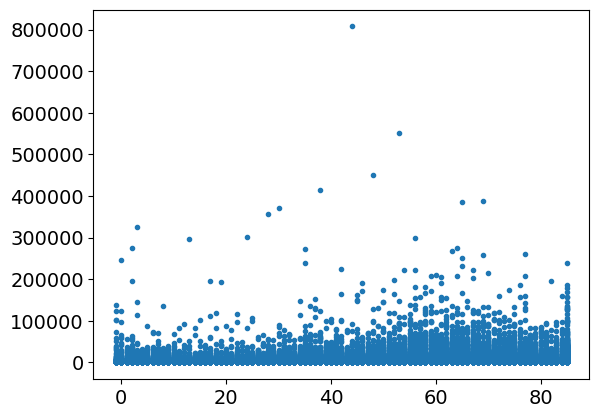

In [147]:
plt.scatter(X.AGE42X, y.TOTEXP18, marker='.')

In [10]:
# Statistically confirm that the data is(/not) heteroscedastic

ols = sm.OLS(y, X)
ols_result = ols.fit()

In [149]:
ols_result.mse_model

162998186494.91666

In [11]:
# residuals of a LM are dependent on X
# plt.scatter(X.EngDispl, ols_result.resid)

In [12]:
# statistical tests confirm this:
het_white(ols_result.resid, X)

(54.0968107062788,
 1.8094931853895402e-08,
 6.019473686842399,
 1.780775674077856e-08)

In [13]:
het_breuschpagan(ols_result.resid, X, robust=False)

(6291.506265364587, 0.0, 13.964826218365822, 4.282812240427314e-09)

In [14]:
torch.set_default_dtype(torch.double)

In [15]:
X_torch = torch.from_numpy(X.to_numpy())[:, 1:] #.unsqueeze(-1)
y_torch = torch.from_numpy(y.to_numpy()).squeeze()

In [ ]:
# X_torch

In [19]:
n_test = int(.1 * len(X_torch))
X_test, X_train = X_torch[-n_test:], X_torch[:-n_test]
y_test, y_train = y_torch[-n_test:], y_torch[:-n_test]

In [20]:
# normalize inputs
mu = X_train.mean(dim=0)
std = torch.norm(X_train - mu, dim=0)
# mu
# # std

In [21]:
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std
# X_torch = (X_torch - mu) / std

In [23]:
X_test.shape, X_train.shape 

(torch.Size([3046, 3]), torch.Size([27415, 3]))

In [78]:
X_torch[:100, :].shape

torch.Size([100, 3])

In [138]:
def save_for_plot(model):
    alpha = model.alpha
    model.eval()
    
    # t = torch.linspace(X_torch[:, 1].min(), X_torch[:, 1].max() +0.1 , 100).unsqueeze(-1)
    # print(t.shape)
    with torch.no_grad():
    
        y_pred, sigma_sq = model(X_train[:200,:])
        std_pred = sigma_sq.sqrt()
    
    # t = t.squeeze().numpy()
    y_pred = y_pred.squeeze().numpy()
    std_pred = std_pred.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a = 2*std_pred
    else:
        # 100% confidence interval.
        R = _radius(1, alpha)
        tau = (-R**2)/2 * (std_pred**2) ** (-(alpha-1) / (alpha+1))
        a = np.sqrt(-2 * tau * std_pred**2)
        
    return X_train[:200,0], y_pred, a
    

def plot_model(t, y_pred, a, ax, which="support", fill_color='C0'):
    ax.plot(t, y_pred, color='C0', label="predicted mean")

    ax.fill_between(t,
                    y_pred - a,
                    y_pred + a,
                    alpha=0.2, color=fill_color, label="predicted {}".format(which))
       
    # Plot the truth
    ax.scatter(((X_train[:200,1]+X_train[:200,0]+X_train[:200,2])/3).squeeze().numpy(), y_train[:200].squeeze().numpy(), marker='.', color='C1', label='train')
    # ax.scatter(X_test.squeeze().numpy(), y_test.squeeze().numpy(), marker='x', color='C2', label='test')

    # ax.set_ylim(-10, 370)
    ax.set_xlim(None, t[-1])
    
def save_for_conf(model):
    alpha = model.alpha
    model.eval()
    
    with torch.no_grad():
    
        y_pred_test, sigma_sq_test = model(X_test)
        std_pred_test = sigma_sq_test.sqrt()
    
    y_pred_test = y_pred_test.squeeze().numpy()
    std_pred_test = std_pred_test.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a_test = 2*std_pred_test
    else:
        # 100% confidence interval.
        R_test = _radius(1, alpha)
        tau_test = (-R_test**2)/2 * (std_pred_test**2) ** (-(alpha-1) / (alpha+1))
        a_test = np.sqrt(-2 * tau_test * std_pred_test**2)

    # t_conf = torch.linspace(X_conf.min(), X_conf.max() + .1, len(X_conf)).unsqueeze(-1)
    # with torch.no_grad():
    
    #     y_pred_conf, sigma_sq_conf = model(t_conf)
    #     std_pred_conf = sigma_sq_conf.sqrt()
    
    # t_conf = t_conf.squeeze().numpy()
    # y_pred_conf = y_pred_conf.squeeze().numpy()
    # std_pred_conf = std_pred_conf.squeeze().numpy()

    # if alpha == 1:
    #     # 95% confidence interval.
    #     a_conf = 2*std_pred_conf
    # else:
    #     # 100% confidence interval.
    #     R_conf = _radius(1, alpha)
    #     tau_conf = (-R_conf**2)/2 * (std_pred_conf**2) ** (-(alpha-1) / (alpha+1))
    #     a_conf = np.sqrt(-2 * tau_conf * std_pred_conf**2)
    return y_test, y_pred_test, a_test, #y_conf, y_pred_conf, a_conf
    



In [132]:
X_train[:, 1].squeeze().shape

torch.Size([27415])

In [133]:
# baseline

torch.manual_seed(42)
bl_model = BetaGaussianLM(input_size=3, uncertainty=False, heteroscedastic=False, alpha=None)
optimizer = torch.optim.LBFGS(bl_model.parameters(), lr=.01, max_iter=100)

n_epochs = 1000

for epoch in range(n_epochs):
    # Forward pass
    
    def closure():
        optimizer.zero_grad()
        bl_model.train()
        loss = bl_model.loss(X_train, y_train)
        loss.backward()
        return loss

    optimizer.step(closure)

# evaluate R^2
y_pred_train = bl_model.predict(X_train).detach().numpy()
y_pred_test = bl_model.predict(X_test).detach().numpy()
print("R2 train {:.3f} test {:.3f}".format(
    r2_score(y_pred_train, y_train.numpy()),
    r2_score(y_pred_test, y_test.numpy())))
    
print("w", bl_model.pred_y.weight.data, "b", bl_model.pred_y.bias.data)

R2 train -17.693 test -13.210
w tensor([[559717.6532,  35214.4966, 216965.0861]]) b tensor([6105.5335])


In [134]:
# try lbfgs

old_loss = np.inf

n_epochs = 1000

results = []

for j, alpha in enumerate([1, 4/3, 1.5, 2]):
    for seed in [42,  ]: # 43, 44, 45, 46
        torch.manual_seed(seed)
        model = BetaGaussianLM(input_size=3, uncertainty=True, heteroscedastic=True, alpha=alpha)

        model.pred_y.weight.data[:] = bl_model.pred_y.weight
        model.pred_y.bias.data[:] = bl_model.pred_y.bias
        
        # model.lin.weight.data[:] = bl_model.lin.weight
        # model.lin.bias.data[:] = bl_model.lin.bias
        # model.quad.weight.data[:] = bl_model.quad.weight
        # model.quad.bias.data[:] = bl_model.quad.bias
        optimizer = torch.optim.LBFGS(model.parameters(), lr=.01, line_search_fn='strong_wolfe', max_iter=100)
        
        for epoch in range(n_epochs):
            
            def closure():
                optimizer.zero_grad()
                model.train()
                loss = model.loss(X_train, y_train)
                loss.backward()
                return loss
            
            optimizer.step(closure)
                
        # evaluate R^2
        model.eval()
        y_pred_train = model.predict(X_train).detach().numpy()
        y_pred_test = model.predict(X_test).detach().numpy()
    
        r2 = "R2 train {:.3f} test {:.3f}".format(
            r2_score(y_pred_train, y_train.numpy()),
            r2_score(y_pred_test, y_test.numpy()))
    
        results.append((alpha, save_for_plot(model), r2)) #
        np.savetxt(f"{alpha}_{seed}_{r2}.csv", save_for_conf(model), delimiter=",")


In [135]:
len(results[0][1][0]), len(results[0][1][1]), len(results[0][1][2])

(200, 200, 200)

In [136]:
# results[3][1]

(tensor([ 1.3919e-03,  6.9200e-04,  2.8153e-03,  3.3816e-03, -2.6187e-03,
         -2.8712e-03, -3.2078e-03, -3.3761e-03,  2.2457e-03, -5.1487e-04,
         -4.7840e-03, -4.9523e-03, -9.1397e-04,  9.8834e-04, -6.1078e-03,
         -6.2761e-03, -6.9493e-03,  1.2213e-03, -7.0540e-04,  4.2227e-03,
         -5.1206e-03,  7.8036e-03,  2.7644e-03, -6.2817e-04,  2.9117e-03,
         -2.1979e-03, -2.5345e-03,  9.7353e-03,  5.6029e-03,  6.7281e-04,
          9.5154e-04, -6.1078e-03, -6.1078e-03, -4.2791e-03,  1.5480e-03,
          4.4002e-03, -6.7364e-04, -3.3470e-03, -6.2761e-03, -6.4444e-03,
          4.0881e-03,  4.2225e-03, -2.4286e-03, -2.5390e-03, -6.0236e-03,
         -5.9395e-03,  2.3612e-03, -7.2258e-04, -1.8527e-02,  3.4933e-04,
          4.5874e-03, -3.4149e-03, -3.4990e-03, -5.4346e-03, -6.1078e-03,
         -3.4149e-03, -3.4149e-03, -5.7712e-03,  5.1839e-03,  2.9340e-03,
         -1.8622e-03,  4.0339e-03,  3.6306e-03,  3.8093e-03,  3.2483e-03,
         -6.4444e-03,  4.2179e-03,  3.

Text(0.5, 0, 'ADBMI42')

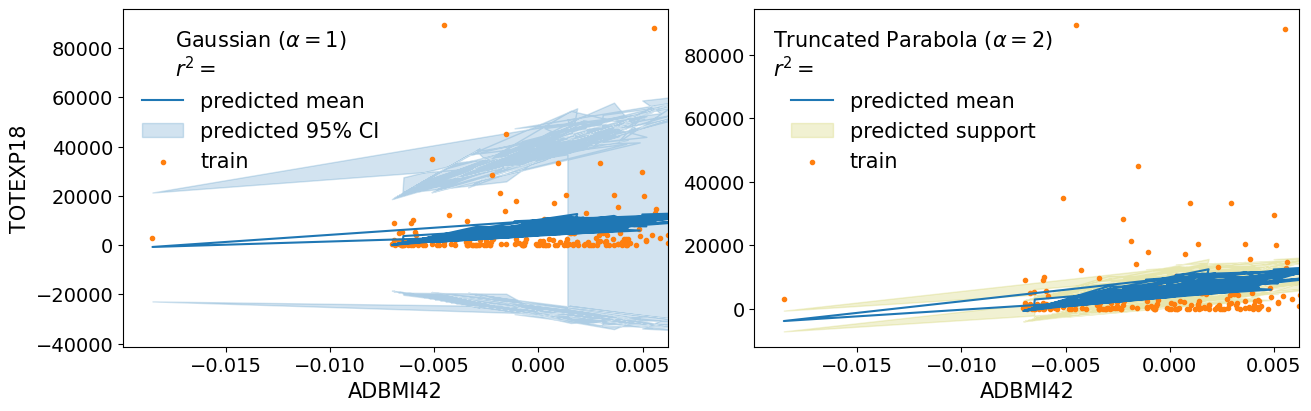

In [137]:
fig, (ax_gauss, ax_tp) = plt.subplots(1, 2, figsize=(13, 4), constrained_layout=True)

plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plot_model(*results[0][1], ax_gauss, "95% CI", fill_color='C0')
plot_model(*results[3][1], ax_tp, "support", fill_color='C8')
ax_gauss.legend(title="Gaussian ($\\alpha=1$)\n$r^2=$", fontsize=15)
ax_tp.legend(title="Truncated Parabola ($\\alpha=2$)\n$r^2=$", fontsize=15)
ax_gauss.set_ylabel("TOTEXP18", fontsize=15)
ax_gauss.set_xlabel("ADBMI42", fontsize=15)
ax_tp.set_xlabel("ADBMI42", fontsize=15)
# plt.savefig("heteroscedastic.pdf")